In [2]:
## Load the data
import math
import pandas as pd
import numpy as np
import seaborn as sns  
import datetime as dt   
sns.set()
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)
path = "/content/gdrive/MyDrive/elula_assignment/"
taxi = pd.read_csv(path+"taxi_dataFare.csv")
taxi.columns = [col.strip().replace(' ', '') for col in taxi.columns]
taxi = taxi.drop('Unnamed:0', axis=1)
#hr_employ = pd.read_csv(path+"hr_employ.csv")
#hr_employ.columns = [col.strip().replace(' ', '') for col in hr_employ.columns]
#hr_employ.drop(columns=hr_employ.columns[0], axis=1, inplace=True)

#from geopy.geocoders import Nominatim
#geolocator = Nominatim()

taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])
taxi['DayofWeek'] = taxi.pickup_datetime.dt.day_name()
taxi['Pick_Hour'] = taxi.pickup_datetime.dt.hour
taxi['pick_date'] = taxi.pickup_datetime.dt.date
taxi['drop_date'] = taxi.pickup_datetime.dt.date
duration = (pd.to_datetime(taxi['dropoff_datetime']) - pd.to_datetime(taxi['pickup_datetime']))/np.timedelta64(1, 's')
taxi['in_car'] = duration



#!python -m pip install basemap
#from mpl_toolkits.basemap import Basemap


Mounted at /content/gdrive


KeyError: ignored

1. What are busiest locations and hours?
2. How are passengers per trip, payment type, fare and tip amounts distributed?
3. How do times and fares vary by trips?
4. Is it possible to characterise taxi drivers based on work hours and how much they make?

In [ ]:

### Busiest Locations 
## Remove excess coords

taxi_zoom = taxi[(taxi.pickup_longitude> -74.5) & (taxi.pickup_longitude < -73.5)]
taxi_zoom = taxi[(taxi.pickup_latitude> 40.5) & (taxi.pickup_latitude < 41)]
taxi_zoom = taxi[(taxi.dropoff_longitude> -74.5) & (taxi.dropoff_longitude < -73.5)]
taxi_zoom = taxi[(taxi.dropoff_latitude> 40.5) & (taxi.dropoff_latitude < 41)]
BBox = (-74.50,   -73.50,  40.5, 41)
# 69 miles ~ 111 km (3 decimals ~ 100m)
pickup_latitude = taxi_zoom.pickup_latitude.round(3)
pickup_longitude = taxi_zoom.pickup_longitude.round(3)
dropoff_latitude = taxi_zoom.dropoff_latitude.round(3)
dropoff_longitude = taxi_zoom.dropoff_longitude.round(3)
pickup = pd.DataFrame({'Lat':pickup_latitude,'Lon':pickup_longitude})
dropoff = pd.DataFrame({'Lat':dropoff_latitude,'Lon':dropoff_longitude})
loc = pickup.value_counts().keys().tolist()
counts = pickup.value_counts(normalize=False).tolist()
location = geolocator.reverse(str(loc[0][0])+","+str(loc[0][1]))
print(location.address)


In [ ]:
#@title visualize busy areas on map
rnd = 2
pickup_latitude = taxi_zoom.pickup_latitude.round(rnd)
pickup_longitude = taxi_zoom.pickup_longitude.round(rnd)
dropoff_latitude = taxi_zoom.dropoff_latitude.round(rnd)
dropoff_longitude = taxi_zoom.dropoff_longitude.round(rnd)
pickup = pd.DataFrame({'Lat':pickup_latitude,'Lon':pickup_longitude})
dropoff = pd.DataFrame({'Lat':dropoff_latitude,'Lon':dropoff_longitude})
loc = pickup.value_counts().keys().tolist()
counts = pickup.value_counts(normalize=False).tolist()
for idx in range(6):
  location = geolocator.reverse(str(loc[idx][0])+","+str(loc[idx][1]))
  print(location.address)
lat_long = pd.DataFrame(loc, columns =['lat', 'lon'])
lat_long['freq']=counts

lat_long = lat_long[lat_long.freq > 2000]
####### Plot lat-long
BBox = (-74.1,   -73.70,  40.6, 40.9)
ruh_m = plt.imread(path+'map_zoom.png')
from matplotlib.pyplot import figure
figure(figsize=(6, 6), dpi=180)
plt.scatter(lat_long.lon, lat_long.lat, zorder=1, alpha= 0.2, c=lat_long.freq, s=15, cmap ='Dark2')
#plt.scatter(dropoff_longitude, dropoff_latitude, zorder=1, alpha= 0.2, c='r', s=1)
plt.title('Pick-up location concentrations >2000 (~93%le) @NYC')
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [ ]:
#@title Visualize pickup - dropoff spots in city
####### Plot lat-long
ruh_m = plt.imread(path+'map_zoom.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(pickup_longitude, pickup_latitude, zorder=1, alpha= 0.2, c='b', s=5)
ax.scatter(dropoff_longitude, dropoff_latitude, zorder=1, alpha= 0.2, c='r', s=1)
ax.set_title('Plotting pick-up in blue and drop-off in red on NYC Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

(40.751, -73.994)

In [ ]:
#@title Create hours_engaged data
### Busiest hours => when the taxi is employed
## For each trip: hour_employ(1x24) $\in$ [0,1]
### e.g. trip was from 17:45 to 21:35 then
### hour_employ = [zeros(17,1),45/60,ones(3),35/60,zeros(2)]

pickup_time = pd.to_datetime(taxi['pickup_datetime'])
dropoff_time = pd.to_datetime(taxi['dropoff_datetime'])
pickup_day = pickup_time.dt.day_name()
dropoff_day = dropoff_time.dt.day_name()
employ = np.zeros((taxi.shape[0],24))

for idx in range(taxi.shape[0]):
  pick = pickup_time[idx].time()
  drop = dropoff_time[idx].time()
  pick2 = pick.minute/60+pick.second/3600
  employ[idx][pick.hour] = pick2
  employ[idx][drop.hour] = drop.minute/60+drop.second/3600
  if pickup_day[idx] != dropoff_day[idx]:
    for j in range(math.ceil(pick.hour+pick2),24):
      employ[idx][j] = 1
    for j in range(0,drop.hour):
      employ[idx][j] = 1
  else:
    for j in range(math.ceil(pick.hour+pick2),drop.hour):
      employ[idx][j] = 1

hr_employ = pd.DataFrame(employ, columns = [str(i) for i in range(24)] )

#hr_employ.to_csv(path+'hr_employ.csv')


In [ ]:
#@title Visualize hours that the taxis are employed
s= hr_employ.sum()
fig, ax = plt.subplots(figsize=(7.5,5))
ax = s.plot(kind='bar', cmap='Accent', legend=False, rot=0, ax=ax)
ax.set_xlabel('Hours in a Day')
ax.set_ylabel('No. of Hours (Taxis Engaged) ', fontsize=14)
fig.suptitle('Engagement over  month', fontsize=16)
plt.ticklabel_format(style='plain', axis='y')

strng = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
s = hr_employ[(pickup_day == strng[0])].sum()
strng = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for idx in range(7):
  s = hr_employ[(pickup_day == strng[idx])].sum()
  fig, ax = plt.subplots(figsize=(6.5,2))
  ax = s.plot(kind='bar', cmap='Accent', legend=False, rot=0, ax=ax)
  ax.set_xlabel('Hours in a Day')
  ax.set_ylabel('No. of Hours', fontsize=14)
  fig.suptitle('Engagement over '+strng[idx], fontsize=16)
  plt.ticklabel_format(style='plain', axis='y')


In [ ]:
####### Distribution of Passengers
sns.distplot(taxi['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()
taxi = taxi[taxi.payment_type != 'NOC']
pay = taxi.payment_type.value_counts(normalize=True)
pay = pay.to_frame().reset_index()
pay = pay.rename(columns={'index':'Type', 'payment_type':'Frequency'})
pay = pay.replace('CRD','Card')
pay = pay.replace('CSH','Cash')
pay = pay.replace('DIS', 'Dispute')
pay = pay.replace('UNK','Unknown')
pay.set_index('Type', inplace=True)
fig, ax = plt.subplots(figsize=(6,4))
ax = pay.plot(kind='bar', cmap='Accent', legend=False, rot=0, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Percentage of Trips', fontsize=14)
fig.suptitle('53.9% payments with card and 46% in cash', fontsize=16)
plt.ticklabel_format(style='plain', axis='y')

############ Visualize tips distribution acc to rate code
taxi2 = taxi[['rate_code','tip_amount','passenger_count']]
taxi2.groupby(['rate_code'])['tip_amount'].mean().reset_index().plot(kind='bar',x='rate_code', y='tip_amount')


NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Distribution of Fare Amount')

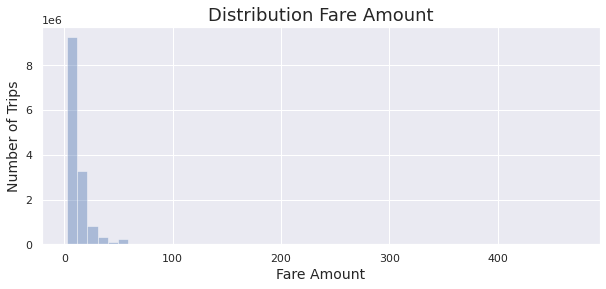

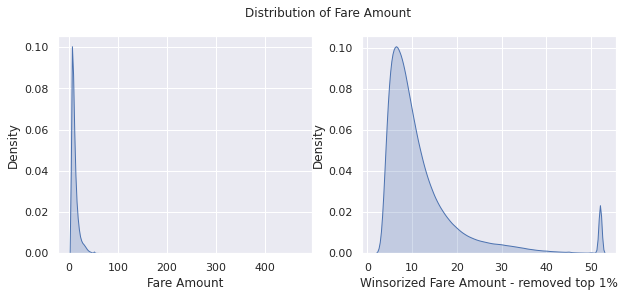

In [ ]:
############## Distribution of fare amounts
winsorized_amt = winsorize(taxi.total_amount, limits=[0.00, 0.01])
median = np.median(winsorized_amt)
lower = stats.scoreatpercentile(winsorized_amt, 5)
upper = stats.scoreatpercentile(winsorized_amt, 95)
(fig, ax) = plt.subplots(figsize=(10,4))
ax = sns.distplot(taxi.fare_amount, kde=False)
ax.set_title('Distribution Fare Amount', fontsize=18)
ax.set_xlabel('Fare Amount', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
(fig, ax) = plt.subplots(1,2, figsize=(10,4))
ax[0] = sns.kdeplot(taxi.fare_amount, legend=False, ax=ax[0], shade=True)
# Remove top and bottom 1% of fare amounts
ax[1] = sns.kdeplot(winsorize(taxi.fare_amount, limits=[0.00, 0.01]), legend=False, ax=ax[1], shade=True)
ax[0].set_xlabel('Fare Amount')
ax[1].set_xlabel('Winsorized Fare Amount - removed top 1%')
fig.suptitle('Distribution of Fare Amount')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


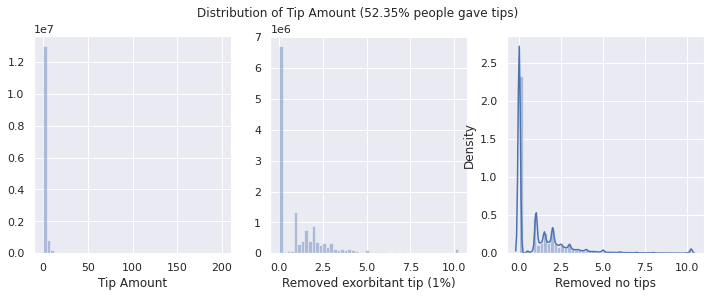

In [ ]:
################# Tip Amount Distribution 7359075.0 are tipping vs  14057949
taxi_tipper = taxi[taxi.tip_amount>0]
(fig, ax) = plt.subplots(1,3, figsize=(12,4))
ax[0] = sns.distplot(taxi.tip_amount, ax=ax[0], kde=False)
# Remove top and bottom 1% of fare amounts
ax[1] = sns.distplot(winsorize(taxi.tip_amount, limits=[0.0, 0.01]), ax=ax[1], kde=False)
ax[0].set_xlabel('Tip Amount')
ax[1].set_xlabel('Removed exorbitant tip (1%)')
ax[2] = sns.distplot(winsorize(taxi.tip_amount, limits=[0.0, 0.01]), ax=ax[2], kde=True)
ax[2].set_xlabel('Removed Tip amt=0')
fig.suptitle('Distribution of Tip Amount (52.35% people gave tips)')
del taxi_tipper

In [ ]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])
taxi['DayofWeek'] = taxi.pickup_datetime.dt.day_name()
taxi['Pick_Hour'] = taxi.pickup_datetime.dt.hour
taxi['pick_date'] = taxi.pickup_datetime.dt.date
taxi['drop_date'] = taxi.dropoff_datetime.dt.date
duration = (pd.to_datetime(taxi['dropoff_datetime']) - pd.to_datetime(taxi['pickup_datetime']))/np.timedelta64(1, 's')
taxi['in_car'] = duration

In [8]:
print(f"There are {taxi.medallion.nunique()} taxis, each earning ${taxi.groupby(['medallion', 'drop_date'])['total_amount'].sum().mean()} daily on an avg")
print(f"There are {taxi.hack_license.nunique()} drivers, each earning ${taxi.groupby(['hack_license', 'drop_date'])['total_amount'].sum().mean()} per day on an avg"")

##### Is it possible to characterise taxi drivers based on work hours and how much they make?
### yeah why not?

print(f"A taxi earns ${taxi.groupby(['medallion', 'drop_date'])['total_amount'].sum().mean()} per day on an avg")
print(f"A driver earns ${taxi.groupby(['hack_license', 'drop_date'])['total_amount'].sum().mean()} per day on an avg")
# Max revenue per driver
dailyAmt_driver = taxi.groupby(['hack_license', 'drop_date'])['total_amount'].sum().sort_values(ascending=False)
monthlyAmt_driver = taxi.groupby(['hack_license'])['total_amount'].sum().sort_values(ascending=False)
# Max revenue per taxi
taxi.groupby(['medallion', 'drop_date'])['total_amount'].sum().sort_values(ascending=False)

########## hr_eng = pd.concat([taxi[['hack_license','drop_date','fare_amount','tip_amount']],hr_employ])
#### sort_driver = hr_eng.groupby(['hack_license']) ### crashes everytime!!$%@$#^@$
id = []
earned = []
for  cnt, earn in enumerate(monthlyAmt_driver):
  #print(monthlyAmt_driver.keys()[cnt])
  #print(f"Fare earned {earn}")
  id.append(monthlyAmt_driver.keys()[cnt])
  earned.append(earn)

earn = pd.DataFrame({'hack_license': id, 'monthly_income': earned})
taxi2 = taxi[['hack_license','drop_date','fare_amount','tip_amount','dropoff_latitude',
              'dropoff_longitude','pickup_longitude','pickup_latitude','in_car']]
del taxi
######## High Income
ls = []
taxi_high = pd.DataFrame(columns=['hack_license','drop_date','fare_amount','tip_amount','dropoff_latitude',
              'dropoff_longitude','pickup_longitude','pickup_latitude','in_car'])
hr_high = pd.DataFrame(columns = [str(i) for i in range(24)])
earn_high = earn[earn['monthly_income']>10000]
#for cnt in range(len(earn_high)):
#  ls.append(taxi2.index[taxi2['hack_license'] == earn_high['hack_license'][cnt]].tolist())
#  taxi_high = taxi_high.append(taxi2.iloc[ls[cnt]], ignore_index=True)
#  hr_high = hr_high.append(hr_employ.iloc[ls[cnt]], ignore_index=True)


############ Low Income



SyntaxError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of Drivers')

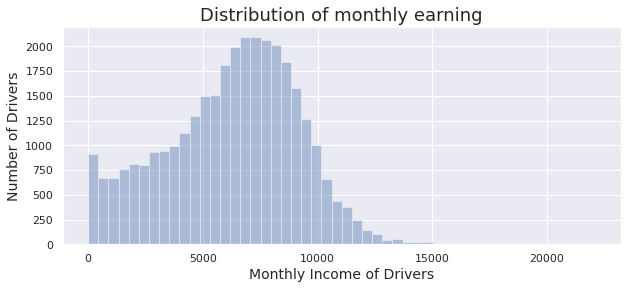

In [ ]:
(fig, ax) = plt.subplots(figsize=(10,4))
ax = sns.distplot(earned, kde=False)
ax.set_title('Distribution of monthly earning', fontsize=18)
ax.set_xlabel('Monthly Income of Drivers', fontsize=14)
ax.set_ylabel('Number of Drivers', fontsize=14)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'Passenger Concentration')

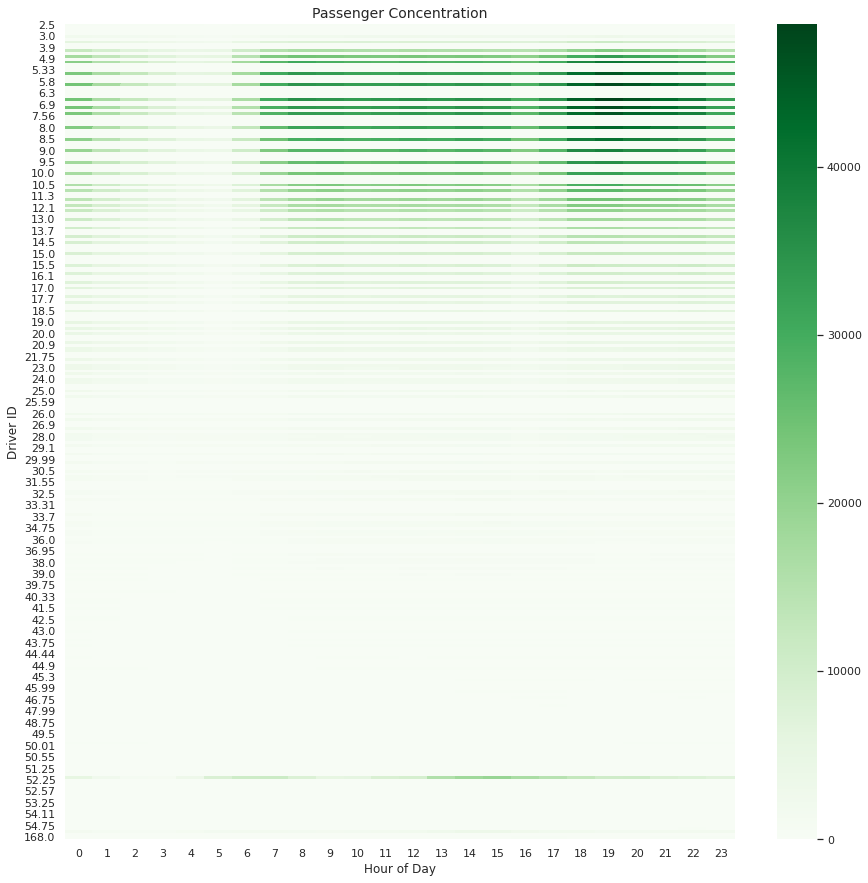

In [ ]:

pass_conc = taxi[['Pick_Hour','fare_amount','hack_license']]
pass_conc.loc[pass_conc.fare_amount > 100, 'fare_amount'] = 168
pass_conc.loc[((pass_conc.fare_amount < 100) & (pass_conc.fare_amount > 55)), 'fare_amount'] = 55.66
pass_conc = pass_conc.groupby(['Pick_Hour','fare_amount'])['hack_license'].size().reset_index()

pass_conc_piv = pd.pivot_table(pass_conc, values="hack_license",index=["fare_amount"], columns=["Pick_Hour"], fill_value=0)
#pass_conc_piv = pass_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
fig, ax = plt.subplots(figsize=(15,13))
ax = sns.heatmap(pass_conc_piv, ax=ax, cmap='Greens')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Driver ID', fontsize=12)
ax.set_title('Passenger Concentration', fontsize=14)


In [ ]:
############## If you were a taxi owner, how would you maximize your earnings in a day?
taxi = pd.read_csv(path+"taxi_dataFare.csv")
taxi.columns = [col.strip().replace(' ', '') for col in taxi.columns]
taxi = taxi.drop('Unnamed:0', axis=1)
# What are the busiest days and hours for taxi drivers?
pass_conc = taxi.groupby(['DayofWeek','Pick_Hour'])['passenger_count'].size().reset_index()
pass_conc_piv = pd.pivot_table(pass_conc, values="passenger_count",index=["Pick_Hour"], columns=["DayofWeek"], fill_value="passenger_count")
pass_conc_piv = pass_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

fare_conc = taxi.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].size().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value="passenger_count")
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots((1,3),figsize=(5,5))
ax[0] = sns.heatmap(pass_conc_piv, ax=ax, cmap='Greens')
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Hour of Day', fontsize=12)
ax[0].set_title('Passenger Concentration', fontsize=14)

ax[1] = sns.heatmap(fare_conc_piv, ax=ax, cmap='Greens')
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Hour of Day', fontsize=12)
ax[1].set_title('Fare Concentration', fontsize=14)

Q4. Is it possible to characterise taxi drivers based on work hours and how much they make?

In [2]:
taxi = taxi[['hack_license','pick_date','total_amount','in_car']]
#hr_employ = pd.read_csv(path+"hr_employ.csv")
#hr_employ.columns = [col.strip().replace(' ', '') for col in hr_employ.columns]
#hr_employ.drop(columns=hr_employ.columns[0], axis=1, inplace=True)
result = pd.concat([taxi, hr_employ], axis=1, join='inner')
del hr_employ
driver_day_trips = result.groupby(['hack_license','pick_date']).sum().reset_index()
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(driver_day_trips.in_car, driver_day_trips.total_amount, zorder=1, alpha= 0.2, c='b', s=5)
ax.set( xlabel= "Duration the Driver is Engaged (s)",ylabel = "Income in ($)")
plt.show()

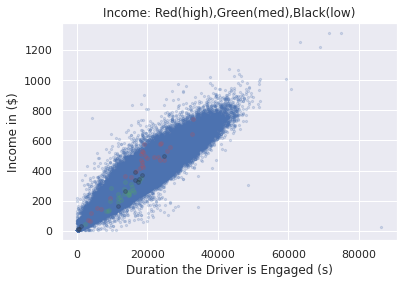

In [48]:
monthly_earnings = driver_day_trips.groupby('hack_license')['total_amount'].sum().reset_index()
high_earning = monthly_earnings[monthly_earnings['total_amount']>12000]
average_earning = monthly_earnings[(monthly_earnings['total_amount']>4000)&(monthly_earnings['total_amount']<8000)]
low_earning = monthly_earnings[(monthly_earnings['total_amount']<3000)]
hi = driver_day_trips[driver_day_trips['hack_license'] == high_earning['hack_license'][69]]
med = driver_day_trips[driver_day_trips['hack_license'] == average_earning['hack_license'][1000]]
low = driver_day_trips[driver_day_trips['hack_license'] == low_earning['hack_license'][629]]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(driver_day_trips.in_car, driver_day_trips.total_amount, zorder=1, alpha= 0.2, c='b', s=5)
ax.scatter(hi.in_car, hi.total_amount, zorder=1, alpha= 0.2, c='r', s=15)
ax.scatter(med.in_car, med.total_amount, zorder=1, alpha= 0.2, c='g', s=15)
ax.scatter(low.in_car, low.total_amount, zorder=1, alpha= 0.2, c='k', s=15)
ax.set( xlabel= "Duration the Driver is Engaged (s)",ylabel = "Income in ($)",title ="Income: Red(high),Green(med),Black(low)")
plt.show()

In [6]:
taxi = pd.read_csv(path+"hr_high.csv")
taxi.columns = [col.strip().replace(' ', '') for col in taxi.columns]
taxi = taxi.drop('Unnamed:0', axis=1)
#taxi.mean().plot(kind='bar',legend=True, title='Hourly engagement of high earners 1 month')


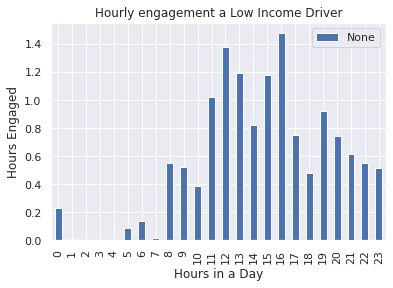

In [71]:

#hi5 = hi[[str(i) for i in range(24) ]] 
#hi5.mean().plot(kind='bar',legend=True, title='Hourly engagement a High Income Driver',xlabel = 'Hours in a Day',ylabel='Hours Engaged')
#med5 = med[[str(i) for i in range(24) ]] 
#med5.mean().plot(kind='bar',legend=True, title='Hourly engagement a Medi Income Driver',xlabel = 'Hours in a Day',ylabel='Hours Engaged')
lo5 = low[[str(i) for i in range(24) ]] 
lo5.mean().plot(kind='bar',legend=True, title='Hourly engagement a Low Income Driver',xlabel = 'Hours in a Day',ylabel='Hours Engaged')


In [ ]:
ax = taxi.plot(kind = "barh", y = "mean", legend = False, title = "Average Avocado Prices", colors = ["steelblue", "seagreen"]) # no error bars added here
# X
ax.set_xlabel("Price ($)")
# Y
ax.set_ylabel("")
ax.set_yticklabels(["Conventional", "Organic"])
# Overall
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.tick_params(bottom = False, left = False)
ax.errorbar(avocado_prices["mean"], avocado_prices.index, xerr = avocado_prices["double_std"], 
            linewidth = 1.5, color = "black", alpha = 0.4, capsize = 4)